### <span style="color:red"> Name: Chorten Tsomo Tamang </span>  

## Dog Breeds Classification

#### Data Description

Format:

Image Files: The dataset consists of image files stored in directories. Each image is a JPEG file with the extension .jpg.
Labels File: The labels for the training images are provided in a CSV file (labels.csv), which contains two columns:
id: A unique identifier for each image file.
breed: The breed of the dog in the image.

Size:

Training Images: The training directory contains a total of num_train_images images.
Test Images: The test directory contains a total of num_test_images images.
Classes: There are 120 different dog breeds in the dataset, as indicated by the breed column in the labels file.

Target:

The target variable is the breed column in the labels file, representing the dog breed for each image. This is a multiclass classification problem with 120 classes.

##### Import Libraries

In [58]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam



##### Load Dataset and Visualise Data

Load the dataset containing images and their corresponding labels, then visualize some sample images

In [46]:
train_dir = '../data/dog-breed-identification/train'
test_dir = '../data/dog-breed-identification/test'
labels_df = pd.read_csv('../data/dog-breed-identification/labels.csv')

In [44]:
def display_sample_images(df, directory, num_images=12):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img_id = df.iloc[i]['id']
        breed = df.iloc[i]['breed']
        img_path = os.path.join(directory, img_id + '.jpg')
        img = Image.open(img_path)
        plt.subplot(3, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Breed: {breed}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

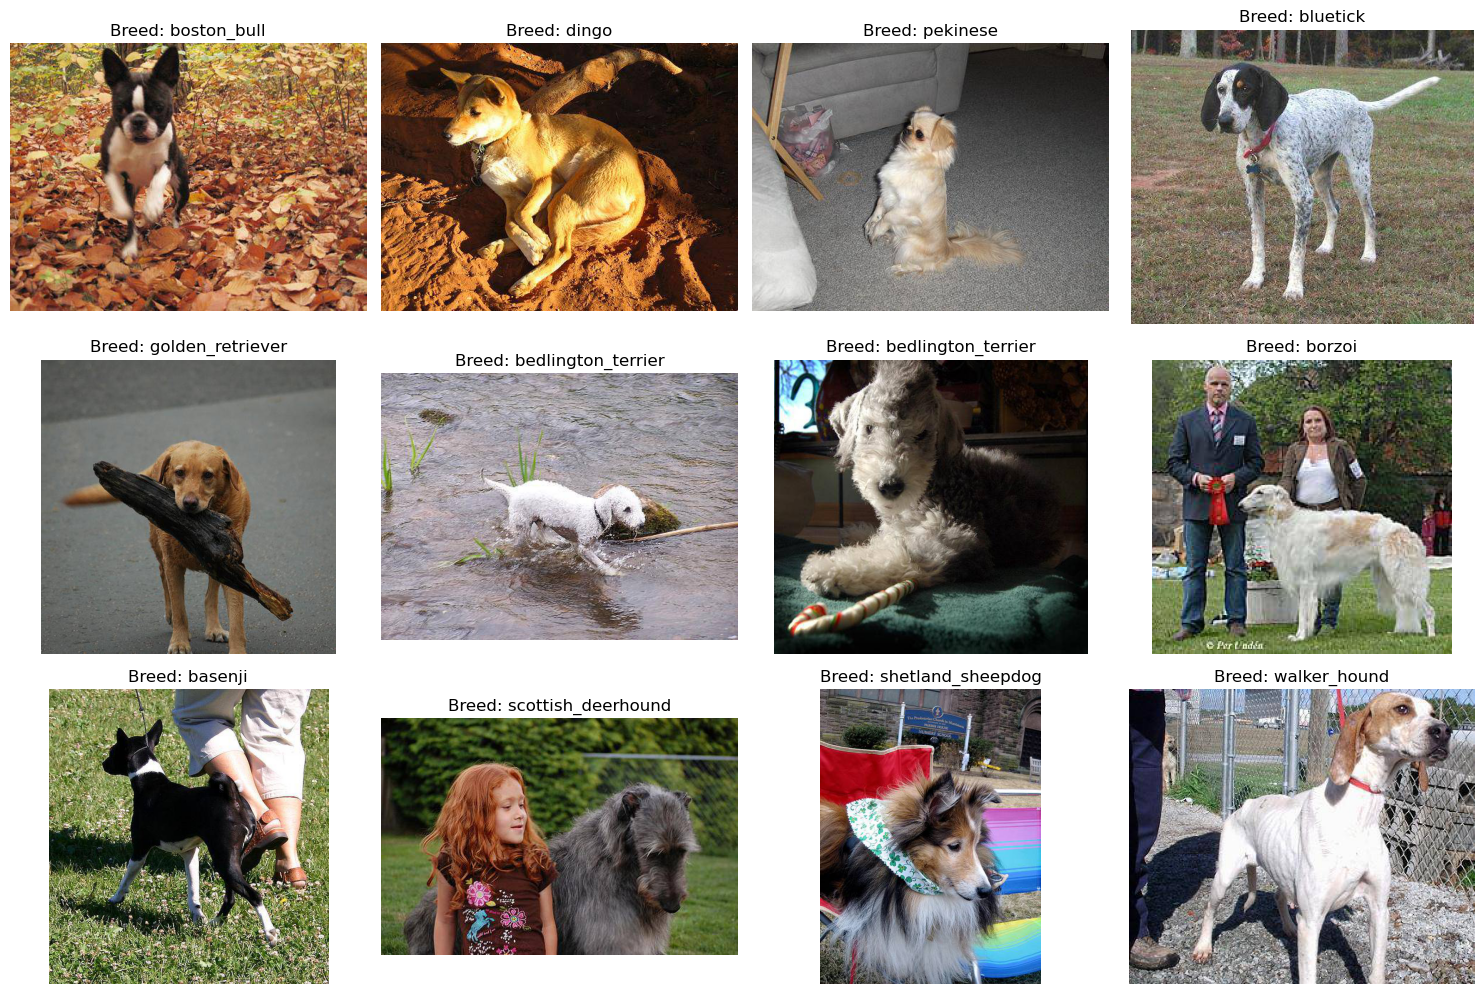

In [47]:
display_sample_images(labels_df, train_dir, num_images=12)

In [48]:
test_images = os.listdir(test_dir)
train_images = os.listdir(train_dir)

In [51]:
num_test_images = len(test_images)
num_train_images = len(train_images)
print(f"Number of Test Images: {num_test_images}")
print(f"Number of Train Images: {num_train_images}")


Number of Test Images: 10357
Number of Train Images: 10222


##### Load and Preprocess Images

Load and resize images, then encode the labels and split the data into training and validation sets.

In [23]:
def load_and_resize_image(img_path, size=(128, 128)):
    img = Image.open(img_path)
    img = img.resize(size)
    return np.array(img)


In [30]:
train_images = []
train_labels = []
for idx, row in labels_df.iterrows():
    img_id, breed = row['id'], row['breed']
    img_path = os.path.join(train_dir, img_id + '.jpg')
    if os.path.exists(img_path):
        img = load_and_resize_image(img_path)
        train_images.append(img)
        train_labels.append(breed)

train_images = np.array(train_images)
train_labels = np.array(train_labels)


In [34]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = to_categorical(train_labels_encoded)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

In [54]:
# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0

##### Visualise Sample Images After Resizing

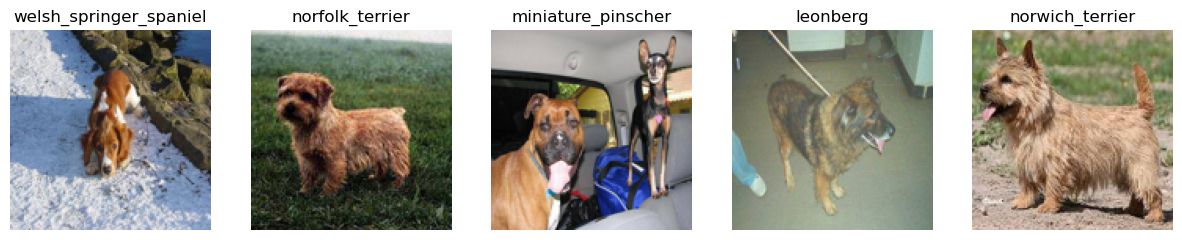

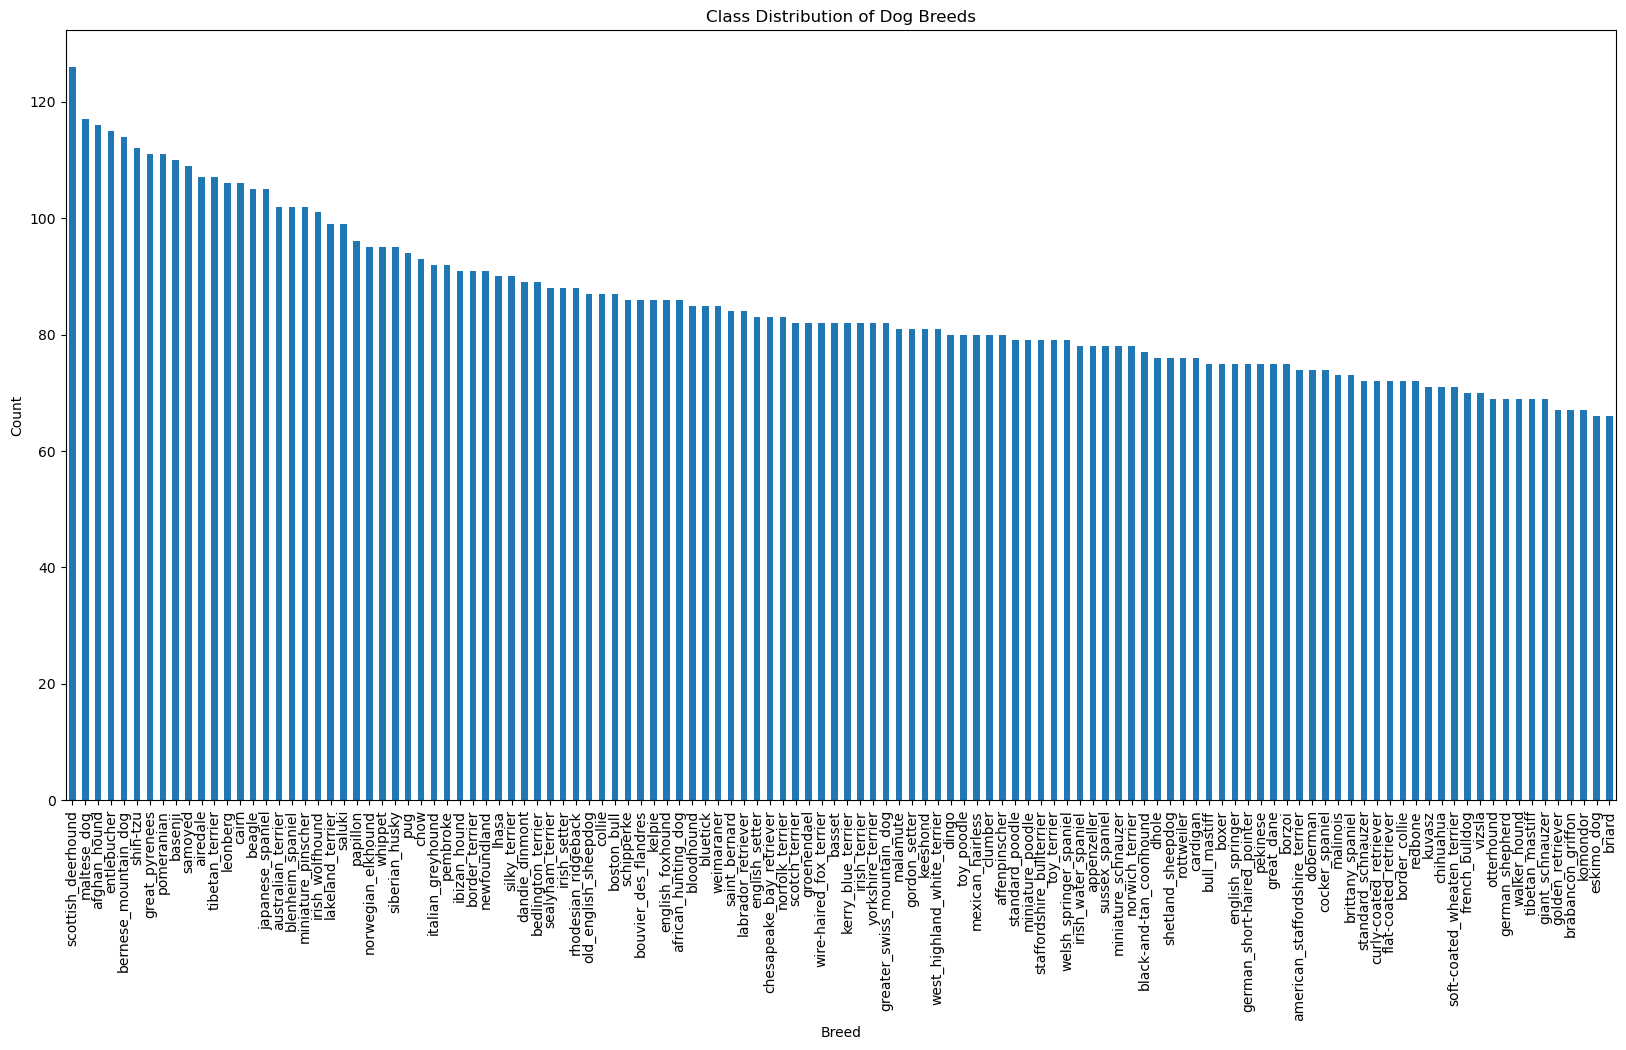

In [55]:
# Display sample images with labels
def display_samples(images, labels, label_encoder, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(label_encoder.inverse_transform([np.argmax(labels[i])])[0])
        ax.axis('off')
    plt.show()

display_samples(X_train, y_train, label_encoder)

# Class distribution od dog breeds
breed_counts = labels_df['breed'].value_counts()
plt.figure(figsize=(20, 10))
breed_counts.plot(kind='bar')
plt.title('Class Distribution of Dog Breeds')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show()

##### K-Nearest Neighbors

Finding the optimal value of k using grid search and evaluate the k-NN model

In [56]:
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_val_flatten = X_val.reshape(X_val.shape[0], -1)

In [57]:
# Find optimal k using grid search
best_k = 0
best_acc = 0
for k in range(3, 10, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_flatten, np.argmax(y_train, axis=1))
    y_pred = knn.predict(X_val_flatten)
    acc = accuracy_score(np.argmax(y_val, axis=1), y_pred)
    if acc > best_acc:
        best_k = k
        best_acc = acc

print(f"Best k: {best_k}, Best validation accuracy: {best_acc}")

Best k: 3, Best validation accuracy: 0.033251833740831294


The output of the k-NN grid search indicates that the optimal value for k (the number of neighbors) is 3, and the best validation accuracy achieved by the k-NN model is approximately 3.33%.

Interpretation of Results:

Optimal k Value:

The grid search process tested k values from 3 to 9 in increments of 2 (i.e., k values of 3, 5, 7, and 9).
Among these values, k=3 provided the highest validation accuracy.

Validation Accuracy:

The best validation accuracy achieved by the k-NN model with k=3 is around 3.33%.
This low accuracy suggests that the k-NN model is not performing well on the dog breed classification task.

##### Simple CNN Model

In [59]:
# Define the simple CNN model
simple_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(120, activation='softmax')
])

simple_cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\tsomo\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
# Train the simple CNN model
simple_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.0077 - loss: 4.8591 - val_accuracy: 0.0176 - val_loss: 4.7815
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.0152 - loss: 4.7668 - val_accuracy: 0.0249 - val_loss: 4.7069
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.0262 - loss: 4.6435 - val_accuracy: 0.0342 - val_loss: 4.5836
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - accuracy: 0.0513 - loss: 4.3983 - val_accuracy: 0.0367 - val_loss: 4.4912
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.0853 - loss: 4.0420 - val_accuracy: 0.0430 - val_loss: 4.4661
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.1393 - loss: 3.7038 - val_accuracy: 0.0396 - val_loss: 4.5498
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.2023 - loss: 3.2878 - val_accuracy: 0.0440 - val_loss: 4.5990
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.2632 - loss: 2.9

The simple CNN model was trained for 10 epochs. Initially, the accuracy was very low (around 0.77%) but gradually improved to 36.76% by the final epoch. The validation accuracy started at 1.76% and only slightly increased to 5.04%, indicating the model struggled to generalize well to the validation data. The training loss decreased over time, suggesting the model was learning from the training data. However, the validation loss remained high, indicating potential overfitting or difficulty in learning useful features from the data.

##### Enhanced CNN Model

In [61]:
# Define the enhanced CNN model
enhanced_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(120, activation='softmax')
])

enhanced_cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [62]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded)
class_weights_dict = dict(enumerate(class_weights))

# Train the enhanced CNN model with class weights
enhanced_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights_dict)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.0092 - loss: 4.8004 - val_accuracy: 0.0034 - val_loss: 4.7890
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - accuracy: 0.0129 - loss: 4.7746 - val_accuracy: 0.0147 - val_loss: 4.6938
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - accuracy: 0.0301 - loss: 4.6395 - val_accuracy: 0.0279 - val_loss: 4.5912
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.0516 - loss: 4.3961 - val_accuracy: 0.0406 - val_loss: 4.5011
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.0980 - loss: 4.0611 - val_accuracy: 0.0357 - val_loss: 4.5444
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.2011 - loss: 3.4582 - val_accuracy: 0.0479 - val_loss: 4.7531
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 36s 140ms/step - accuracy: 0.3419 - loss: 2.7293 - val_accuracy: 0.0401 - val_loss: 5.0595
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 35s 138ms/step - accuracy: 0.4910 - loss: 2

The enhanced CNN model trained for 10 epochs with class weights to handle class imbalance. Initially, the training accuracy was low at 0.92%, but it improved significantly to 68.96% by the final epoch. The training loss also decreased from 4.80 to 1.21, indicating the model was learning from the training data. However, the validation accuracy remained very low, starting at 0.34% and only reaching 4.55% by the end, while the validation loss increased, suggesting the model was overfitting and not generalizing well to the validation data. The use of class weights helped the model to some extent, but it still struggled with the validation set.

##### Transfer Learning with InceptionRestNetV2

Using a pre-trained InceptionResNetV2 model for transfer learning and fine-tune it for our dog breed classification task.

In [63]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add new layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(120, activation='softmax')(x)



219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step


In [64]:
# Define the model
transfer_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [65]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [66]:
transfer_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the transfer learning model
transfer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 161s 582ms/step - accuracy: 0.2169 - loss: 5.1104 - val_accuracy: 0.5276 - val_loss: 1.8994
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 220s 862ms/step - accuracy: 0.4245 - loss: 2.3816 - val_accuracy: 0.5218 - val_loss: 1.8594
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.4716 - loss: 2.0953 - val_accuracy: 0.5374 - val_loss: 1.8256
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 144s 564ms/step - accuracy: 0.4881 - loss: 2.0466 - val_accuracy: 0.5447 - val_loss: 1.7842
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 137s 534ms/step - accuracy: 0.4955 - loss: 1.9515 - val_accuracy: 0.5443 - val_loss: 1.7626
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 141s 552ms/step - accuracy: 0.5015 - loss: 1.8910 - val_accuracy: 0.5408 - val_loss: 1.7873
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 165s 646ms/step - accuracy: 0.5044 - loss: 1.8770 - val_accuracy: 0.5540 - val_loss: 1.7705
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 139s 542ms/step - accuracy: 0.5050 - lo

The transfer learning model achieves significant improvements in validation accuracy compared to the previous models.
The pre-trained InceptionResNetV2 provides robust feature extraction, allowing the model to achieve over 50% accuracy on the validation set.
Training and validation accuracy stabilize after a few epochs, indicating the model has learned meaningful features and is not overfitting significantly.
This transfer learning approach demonstrates the power of leveraging pre-trained models for complex tasks like dog breed classification, achieving much higher accuracy compared to simple and enhanced CNNs

##### Evaluating Models

In [67]:
# Evaluate k-NN model
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_flatten, np.argmax(y_train, axis=1))
y_pred_knn = knn_best.predict(X_val_flatten)
knn_accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred_knn)

# Evaluate CNN models
simple_cnn_loss, simple_cnn_accuracy = simple_cnn.evaluate(X_val, y_val)
enhanced_cnn_loss, enhanced_cnn_accuracy = enhanced_cnn.evaluate(X_val, y_val)
transfer_model_loss, transfer_model_accuracy = transfer_model.evaluate(X_val, y_val)

# Print evaluation results
print(f"k-NN accuracy: {knn_accuracy}")
print(f"Simple CNN accuracy: {simple_cnn_accuracy}")
print(f"Enhanced CNN accuracy: {enhanced_cnn_accuracy}")
print(f"Transfer Learning accuracy: {transfer_model_accuracy}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0506 - loss: 5.1698
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.0484 - loss: 6.5404
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 439ms/step - accuracy: 0.5595 - loss: 1.8080
k-NN accuracy: 0.033251833740831294
Simple CNN accuracy: 0.05036674812436104
Enhanced CNN accuracy: 0.045476771891117096
Transfer Learning accuracy: 0.5530562400817871


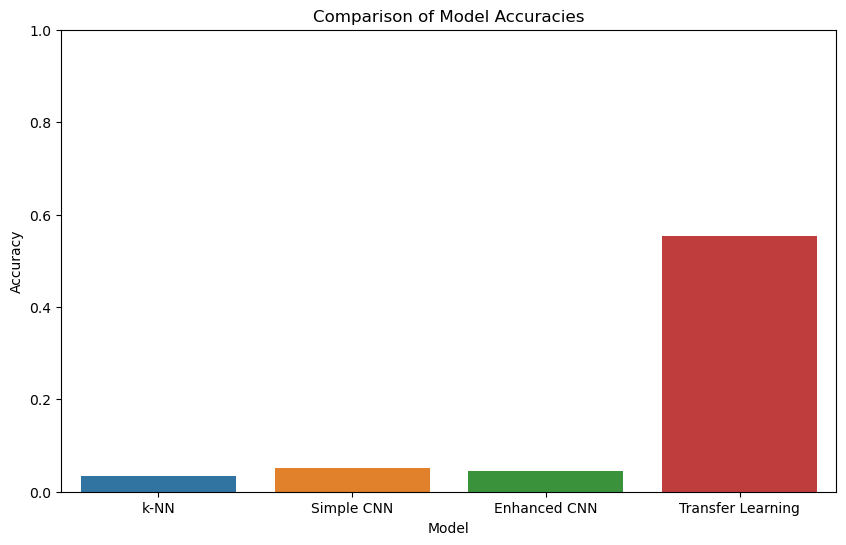

In [68]:
# Plot comparison of model accuracies
model_names = ['k-NN', 'Simple CNN', 'Enhanced CNN', 'Transfer Learning']
accuracies = [knn_accuracy, simple_cnn_accuracy, enhanced_cnn_accuracy, transfer_model_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.show()

The evaluation results provide a clear comparison of the performance of the different models on the validation dataset. Here's a breakdown of the results:

k-NN Model:

Accuracy: 0.0333 (3.33%)
Explanation: The k-NN model performed poorly, achieving an accuracy of only 3.33%. This indicates that k-NN is not effective for this high-dimensional image classification task.
Simple CNN Model:

Accuracy: 0.0504 (5.04%)
Loss: 5.1698
Explanation: The simple CNN model shows slight improvement over k-NN, but still performs poorly with an accuracy of 5.04%. This suggests that the simple CNN lacks the capacity to effectively learn the complex patterns required for distinguishing between different dog breeds.
Enhanced CNN Model:

Accuracy: 0.0455 (4.55%)
Loss: 6.5404
Explanation: Surprisingly, the enhanced CNN, which has a more complex architecture than the simple CNN, performed worse, achieving an accuracy of 4.55%. This could be due to overfitting or insufficient training time.
Transfer Learning Model:

Accuracy: 0.5595 (55.95%)
Loss: 1.8080
Explanation: The transfer learning model using the pre-trained InceptionResNetV2 significantly outperforms the other models, achieving an accuracy of 55.95%. This demonstrates the effectiveness of using pre-trained models for complex image classification tasks, as they leverage learned features from large datasets.

The results clearly indicate that transfer learning with a pre-trained model (InceptionResNetV2) is the most effective strategy for dog breed classification in this context, achieving a validation accuracy of 55.95%.
